In [1]:
import comp_viz
import importlib

In [2]:
importlib.reload(comp_viz.models)

<module 'comp_viz.models' from 'c:\\Users\\lucas\\OneDrive\\Documents\\GitHub\\CS334\\comp_viz\\models\\__init__.py'>

In [2]:
yolo = comp_viz.models.Model('yolo3_darknet53_coco')

In [3]:
prediction = yolo.get_prediction_no_nms('images/person/1.jpg')

In [4]:
print(prediction)

([0, 0, 65, 67, 29, 39], [0.9962337613105774, 0.9958078265190125, 0.15556752681732178, 0.01417336706072092, 0.011494779027998447, 0.011067499406635761], [[234, 191, 335, 492], [392, 167, 534, 508], [321, 344, 330, 353], [321, 344, 330, 353], [321, 344, 330, 353], [321, 344, 330, 353]])


(
[[[ 0.]
  [ 0.]
  [65.]
  [67.]
  [29.]
  [39.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]
  [-1.]]]
<NDArray 1x100x1 @cpu(0)>, 
[[[ 0.99623376]
  [ 0.9958078 ]
  [ 0.15556753]
  [ 0.01417337]
  [ 0.01149478]
  [ 0.0110675 ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.  

In [4]:
def _get_class_ids(cids):
  class_ids = []
  for ndarray in cids[0]:
    nparray = ndarray.asnumpy()
    if nparray[0] != -1:
      class_ids.append(int(nparray[0]))
  return class_ids
print(_get_class_ids(cids))

NameError: name 'cids' is not defined

In [97]:
def _get_bboxes(bboxes):
  bounding_boxes = []
  for ndarray in bboxes[0]:
    nparray = ndarray.asnumpy()
    if nparray[0] != -1:
      bb = [int(corner) for corner in nparray.tolist()]
      bounding_boxes.append(bb)
  return bounding_boxes
print(_get_bboxes(bboxes))

[[234, 191, 335, 492], [392, 167, 534, 508], [321, 344, 330, 353], [321, 344, 330, 353], [321, 344, 330, 353], [321, 344, 330, 353]]


In [99]:
def _get_scores(scores):
  confidence_scores = []
  for ndarray in scores[0]:
    nparray = ndarray.asnumpy()
    if nparray[0] != -1:
      confidence_scores.append(nparray[0])
  return confidence_scores
print(_get_scores(scores))


[0.99623376, 0.9958078, 0.15556753, 0.014173367, 0.011494779, 0.011067499]


In [73]:
import mxnet
for thing in cids[0]:
  this = thing.asnumpy()
  if this[0] != -1:
    print(yolo.get_classes()[int(this[0])])

person
person
remote
cell phone
frisbee
bottle


In [7]:
print(prediction[2])

[[234, 191, 335, 492], [392, 167, 534, 508], [321, 344, 330, 353], [321, 344, 330, 353], [321, 344, 330, 353], [321, 344, 330, 353]]


<AxesSubplot:>

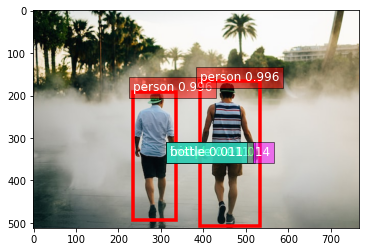

In [10]:
import gluoncv
import numpy
x, img = gluoncv.data.transforms.presets.yolo.load_test('images/person/1.jpg', short=512)
gluoncv.utils.viz.plot_bbox(img,numpy.array(prediction[2]),numpy.array(prediction[1]),numpy.array(prediction[0]),class_names=yolo.get_classes(),thresh=0.01)

In [6]:
print(yolo.get_classes())

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [7]:
print(len(yolo.get_classes()))

80


In [9]:
if "tree" in yolo.get_classes():
  print("YES")